Import `pyswip` and consult the Prolog background knowledge base.

In [39]:
from pyswip import Prolog
prolog = Prolog()
prolog.consult('mnist_sum.pl')
target = 10
for soln in prolog.query("abduce([X,Y], {})".format(target)):
    print(soln["X"], "adds", soln["Y"], "equals {}.".format(target))

1 adds 9 equals 10.
2 adds 8 equals 10.
3 adds 7 equals 10.
4 adds 6 equals 10.
5 adds 5 equals 10.
6 adds 4 equals 10.
7 adds 3 equals 10.
8 adds 2 equals 10.
9 adds 1 equals 10.


In [40]:
from pyswip import Prolog
prolog = Prolog()
prolog.consult('paraconsistent.pl')
target = 10
for soln in prolog.query("abduce([X,Y], {})".format(target)):
    print(soln["X"], "adds", soln["Y"], "equals {}.".format(target))

1 adds 9 equals 10.
2 adds 8 equals 10.
3 adds 7 equals 10.
4 adds 6 equals 10.
5 adds 5 equals 10.
6 adds 4 equals 10.
7 adds 3 equals 10.
8 adds 2 equals 10.
9 adds 1 equals 10.


Test if the `CLP(FD)`-based abduction in the background knowledge base works correctly.

# Abductive Learning

Now let's try to implement the MNIST sum learning algorithm using the Abductive Learning framework.

### Dataset Generation

Directly copy the codes from the `data_generator.ipynb` notebook file.

In [41]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('data', train=True, download=True,
                            transform=transform)
dataset2 = datasets.MNIST('data', train=False,
                            transform=transform)

device = torch.device("cpu")

digit_groups_train = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
digit_groups_test = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for i in range(len(dataset1)): 
    digit_groups_train[int(dataset1.targets[i])].append(i)
for i in range(len(dataset2)): 
    digit_groups_test[int(dataset2.targets[i])].append(i)

In [42]:
class MNIST_Sum:
    def __init__(self, num, digit_groups):
        self.targets = []
        self.img_indices = [] # list of lists of 2 ids
        self.ground_truth = []
        self.length = num
        for i in range(num):
            # sampling two numbers from 0 to 9
            sampled_digits = np.random.choice(10, 2)
            self.ground_truth.append(list(sampled_digits))

            # using the sum of the sampled digits as the target
            self.targets.append(sum(sampled_digits))
            ids = []
            for j in range(len(sampled_digits)):
                # get the j-th digits
                digit = sampled_digits[j]
                # total number of the images of the digit
                ids.append(np.random.choice(digit_groups[digit]))
            self.img_indices.append(ids)

# Generate the training and test dataset for MNIST Sum task
mnist_sum_data_train = MNIST_Sum(3000, digit_groups_train)
mnist_sum_data_test = MNIST_Sum(3000, digit_groups_test)

### The Machine Learning Part

Neural networks for image classification.

In [43]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

device = torch.device("cpu")

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def conv_net(outdim, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(1, 32, 3, 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        Flatten(),
        nn.Linear(9216, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, outdim),
        nn.LogSoftmax(dim=1)
    )


def auto_enc(outdim, *args, **kwargs):
    return nn.Sequential(
        nn.Linear(outdim, 128),
        nn.ReLU(),
        nn.Linear(128, 784)
    )


def mlp(indim, outdim, *args, **kwargs):
    return nn.Sequential(
        nn.Linear(indim, 32),
        nn.ReLU(),
        nn.Linear(32, outdim),
        nn.LogSoftmax(dim=1),
    )

class LSTM(nn.Module):
    """A (Bi)LSTM Model.

    Attributes:
        num_layers: the number of LSTM layers (number of stacked LSTM models) in the network.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
        activation: the activation function.
        bidirectional: the flag for bidirectional LSTM
        dropout: the dropout rate if num_layers > 1
    """

    def __init__(self, num_layers, in_dim, hidden_dim, out_dim,
                 bidirectional=False, dropout=0):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.bidirectional = bidirectional
        self.dropout = dropout

        self.lstm = nn.LSTM(self.in_dim,
                            self.hidden_dim,
                            num_layers=self.num_layers,
                            bidirectional=self.bidirectional,
                            dropout=self.dropout,
                            batch_first=True)
        fc_dim = self.hidden_dim * 2 if self.bidirectional else self.hidden_dim
        self.fc = nn.Linear(fc_dim, self.out_dim)

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        outputs = self.fc(lstm_out[:, -1, :])
        outputs = torch.sigmoid(outputs)
        return outputs

    def loss_function(self, pred, y):
        return F.binary_cross_entropy(pred, y.view(y.shape[0], -1))


class Net(nn.Module):
    outdim = 10

    def __init__(self, outdim):
        super(Net, self).__init__()
        self.outdim = outdim
        self.enc = conv_net(outdim)

    def forward(self, x):
        output = self.enc(x)
        return output

    def loss_function(self, pred, y):
        return F.nll_loss(pred, y)

def train(model, device, train_loader, optimizer, epoch,
          log_interval=1000, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss_function(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += model.loss_function(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('-- Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


### The Logic Abduction Part

It involves the following steps:
1. Given the target (label, i.e., the sum of the two images), using `pyswip` to abduce possible pseudo-labels for them.
2. Calculate the probability of each pair of pseudo-labels.
3. Return the most probable pseudo-labels to retrain the neural network.

_Remark_: For more complicated problems, a better way of searching for the best pseudo-labels is required.

##### Abducing possible pseudo-labels given the sum

- `pl` is the Prolog instance that consulted `mnist_sum.pl`;
- `target` is the sum of two images.

In [44]:
def abduce(pl, target):
    # This abduce/2 function is defined in "mnist_sum.pl"
    ans = [];
    for soln in pl.query("abduce([X,Y], {})".format(target)): # given targer, abduce X and Y
        ans.append([soln["X"], soln["Y"]])
    if len(ans) > 0:
        return ans
    else:
        return None

Test the `abduce` function.

In [47]:
print(abduce(prolog, 5))

[[0, 5], [1, 4], [2, 3], [3, 2], [4, 1], [5, 0]]


##### The Abductive Learning Procedure

Importing useful libraries and set the default neural network training parameters within the Abductive Learning Process.

In [48]:
from tqdm import tqdm

nn_train_kwargs = {'batch_size': 64, 'shuffle': True}
nn_epoch = 2


nn_test_loader = torch.utils.data.DataLoader(dataset2, **nn_train_kwargs)

Useful functions for abduction:
1. `get_mnist_imgs`: given `indices`, sample a subset of images from `dataset` (such as the `MNIST` dataset).
2. `best_pseudo_label`: given a set of abduced possible pseudo-labels and the pseudo-label distribution, return the most probable pseudo-label combination for each image. 

In [49]:
def get_mnist_imgs(dataset, indices, use_cuda=False):
    """
    Get the image tensor from mnist dataset by indices
    """

    n = len(indices)
    img_tensor, tgt = dataset[indices[0]]
    img_tensor = torch.reshape(img_tensor, (1, 1, 28, 28))
    targets = [tgt]
    i = 1
    while i < n:
        img, tgt = dataset[indices[i]]
        img = torch.reshape(img, (1, 1, 28, 28))
        img_tensor = torch.cat((img_tensor, img), 0)
        targets.append(tgt)
        i = i + 1
    if use_cuda:
        img_tensor = img_tensor.to(torch.device("cuda"))
    return img_tensor, targets # list of image tensors and list of its targets

def best_pseudo_label(pseudo_label_lists, pseudo_label_dist):
    """
    Given plabel lists and plabel distribution list
    Return the best combination with score
    """
    best_score = -100000.0
    best_combi = np.zeros(pseudo_label_dist.shape[0])
    probabilities = np.exp(pseudo_label_dist)
    for label_combi in pseudo_label_lists:
        # because the scores are log_softmax, the log probability can be calculated as sum
        score = 1.0
        for j in range(len(label_combi)):
            score = score*probabilities[j, label_combi[j]]
        if score >= best_score:
            best_score = score
            best_combi = label_combi
    return best_combi, score


Main procedure for abductive Learning. Given a machine learning `model` and a prolog instance `pl` with `dataset`, it does the following steps:
1. Using `model` to predict the pseudo-label probabilistic distribution of `dataset`;
2. Finding the best pseudo-label combination considering both the abduction result from `pl` and the pseudo-label probabilistic distribution;
3. Retrain the neural network with the abduced pseudo-labels.

In [50]:
def ABL_main(model, pl, dataset, optimizer=None, scheduler=None):
    # number of examples
    num_examples = dataset.length
    abduced_data_ids = [] # list of ids
    abduced_labels = [] # list of labels
    ground_truth_labels = [] # list of targets

    # start abduction
    for i in tqdm (range(num_examples), desc="Abducing..."):
        target = int(dataset.targets[i])
        possible_pseudo_labels = abduce(pl, target) # given target, generate possible pseudo labels
        if possible_pseudo_labels is not None:
            # reshape the tensor of the two MNIST images to match NN model's input dimensions
            img_indices = dataset.img_indices[i] # get the ids for the two images
            imgs, _ = get_mnist_imgs(dataset1, img_indices, use_cuda=False) # get the two img tensors

            pseudo_label_distribution = model(imgs).detach().numpy() # the Net

            # find the pseudo-labels with the maximum likelihood
            abduced_pseudo_labels, _ = best_pseudo_label(possible_pseudo_labels, pseudo_label_distribution)

            # for abduced dataset
            abduced_data_ids = abduced_data_ids + img_indices

            abduced_labels = abduced_labels + abduced_pseudo_labels
            ground_truth_labels = ground_truth_labels + dataset.ground_truth[i]

    # changing the training data labels to the abduced labels
    for i, img in enumerate(abduced_data_ids):
        dataset1.targets[img] = abduced_labels[i]
    
    abduction_accuracy = np.sum(np.array(ground_truth_labels) == np.array(abduced_labels))/len(abduced_labels)


    # making new dataset with abduced labels
    abduced_data = torch.utils.data.Subset(dataset1, abduced_data_ids)

    # training the neural network model
    abduced_train_loader = torch.utils.data.DataLoader(abduced_data, batch_size=64)
    

    for epoch in range(1, nn_epoch + 1):
        train(model, device, abduced_train_loader, optimizer, epoch)
        print("Abduction accuracy: ", abduction_accuracy)
        scheduler.step()
    test(model, device, nn_test_loader)


### Running Experiment

Initialise model and optimizer.

In [51]:
mnist_sum_data_train.targets[0]

7

tensor([[4],
        [4]])


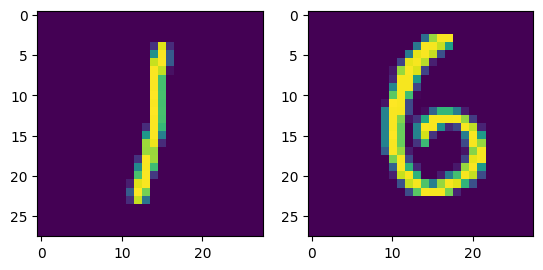

In [54]:
model.eval()
img_indices = mnist_sum_data_train.img_indices[0] # get the ids for the two images
imgs, _ = get_mnist_imgs(dataset1, img_indices, use_cuda=False) # get the two img tensors
# Plot them
_, axs = plt.subplots(1,2)
axs[0].imshow(dataset1.data[img_indices[0], :, :])
axs[1].imshow(dataset1.data[img_indices[1], :, ])
pseudo_label_distribution = model(imgs).detach().numpy() # the Net


print(model(imgs).argmax(dim=1, keepdim=True))

In [33]:
possible_pseudo_labels = abduce(prolog, 6) # given target, generate possible pseudo labels
pseudo_label_distribution = model(imgs).detach().numpy() # the Net
abduced_pseudo_labels, _ = best_pseudo_label(possible_pseudo_labels, pseudo_label_distribution)
abduced_pseudo_labels

            

[1, 5]

In [57]:
model = Net(outdim=10).to(device)

optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [1]:
for epoch in range(1, nn_epoch + 1):
        normaltrain = torch.utils.data.DataLoader(dataset1, batch_size=64)
        train(model, device, normaltrain, optimizer, epoch)
        scheduler.step()
        test(model, device, nn_test_loader)

NameError: name 'nn_epoch' is not defined

##### Run Abductive Learning without any pre-train.

In [ ]:
ABL_epochs = 5
for epoch in range(ABL_epochs):
    ABL_main(model, prolog, mnist_sum_data_train, optimizer=optimizer, scheduler=scheduler)

In [12]:
ABL_epochs = 5
for epoch in range(ABL_epochs):
    ABL_main(model, prolog, mnist_sum_data_train, optimizer=optimizer, scheduler=scheduler)

Abducing...: 100%|██████████| 3000/3000 [00:32<00:00, 91.21it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.258973
Abduction accuracy:  0.22833333333333333
Train Epoch: 2 [0/6000 (0%)]	Loss: 2.106419
Abduction accuracy:  0.22833333333333333
-- Test set: Average loss: 0.0327, Accuracy: 2969/10000 (30%)


Abducing...: 100%|██████████| 3000/3000 [00:31<00:00, 95.85it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 1.802510
Abduction accuracy:  0.438
Train Epoch: 2 [0/6000 (0%)]	Loss: 1.359203
Abduction accuracy:  0.438
-- Test set: Average loss: 0.0220, Accuracy: 4786/10000 (48%)


Abducing...: 100%|██████████| 3000/3000 [00:28<00:00, 106.02it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 1.242864
Abduction accuracy:  0.6496666666666666
Train Epoch: 2 [0/6000 (0%)]	Loss: 1.289982
Abduction accuracy:  0.6496666666666666
-- Test set: Average loss: 0.0124, Accuracy: 7156/10000 (72%)


Abducing...: 100%|██████████| 3000/3000 [00:31<00:00, 94.73it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.956407
Abduction accuracy:  0.8726666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.751012
Abduction accuracy:  0.8726666666666667
-- Test set: Average loss: 0.0057, Accuracy: 9076/10000 (91%)


Abducing...: 100%|██████████| 3000/3000 [00:32<00:00, 92.40it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.592407
Abduction accuracy:  0.9776666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.539589
Abduction accuracy:  0.9776666666666667
-- Test set: Average loss: 0.0033, Accuracy: 9448/10000 (94%)


Abducing...: 100%|██████████| 3000/3000 [00:32<00:00, 93.57it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.362854
Abduction accuracy:  0.9923333333333333
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.447820
Abduction accuracy:  0.9923333333333333
-- Test set: Average loss: 0.0029, Accuracy: 9531/10000 (95%)


Abducing...: 100%|██████████| 3000/3000 [00:31<00:00, 95.28it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.480746
Abduction accuracy:  0.9943333333333333
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.360771
Abduction accuracy:  0.9943333333333333
-- Test set: Average loss: 0.0027, Accuracy: 9558/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:33<00:00, 90.45it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.297648
Abduction accuracy:  0.995
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.457465
Abduction accuracy:  0.995
-- Test set: Average loss: 0.0027, Accuracy: 9562/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:32<00:00, 91.29it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.478222
Abduction accuracy:  0.9953333333333333
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.415555
Abduction accuracy:  0.9953333333333333
-- Test set: Average loss: 0.0027, Accuracy: 9567/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:30<00:00, 99.86it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.388577
Abduction accuracy:  0.9953333333333333
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.490199
Abduction accuracy:  0.9953333333333333
-- Test set: Average loss: 0.0026, Accuracy: 9566/10000 (96%)


##### Run Abductive Learning with one-shot pre-train

Sample an one-shot training dataset.

In [13]:
import random

# reset the machine learning model
model = Net(outdim=10).to(device)

# reset dataset1 to reset the labels for one-shot training, 
# since the previous abductive learning process has changed 
# the ground truth labels in dataset1
dataset1 = datasets.MNIST('data', train=True, download=True,
                            transform=transform)

n_samples = 1
few_shot_indices = []

for i in range(10):
    few_shot_indices = few_shot_indices + \
        random.sample(digit_groups_train[i], n_samples)

# few_shot_indices = random.sample(all_img_indices, n_samples)

sup_imgs_train = torch.utils.data.Subset(dataset1, few_shot_indices)

sup_train_loader = torch.utils.data.DataLoader(
    sup_imgs_train, **nn_train_kwargs)

optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(1, 5):
    train(model, device, sup_train_loader,
        optimizer, epoch)
    #test(model, device, nn_test_loader)
    scheduler.step()
test(model, device, nn_test_loader)

Train Epoch: 1 [0/10 (0%)]	Loss: 2.337119
Train Epoch: 2 [0/10 (0%)]	Loss: 2.096287
Train Epoch: 3 [0/10 (0%)]	Loss: 1.946862
Train Epoch: 4 [0/10 (0%)]	Loss: 1.636731
-- Test set: Average loss: 0.0306, Accuracy: 3867/10000 (39%)


In [14]:
ABL_epochs = 20
for epoch in range(ABL_epochs):
    ABL_main(model, prolog, mnist_sum_data_train, optimizer=optimizer, scheduler=scheduler) #check

Abducing...: 100%|██████████| 3000/3000 [00:30<00:00, 97.97it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 1.958068
Abduction accuracy:  0.6456666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 1.296085
Abduction accuracy:  0.6456666666666667
-- Test set: Average loss: 0.0137, Accuracy: 7669/10000 (77%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 101.59it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.926988
Abduction accuracy:  0.9103333333333333
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.585736
Abduction accuracy:  0.9103333333333333
-- Test set: Average loss: 0.0046, Accuracy: 9210/10000 (92%)


Abducing...: 100%|██████████| 3000/3000 [00:30<00:00, 99.83it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.608485
Abduction accuracy:  0.9873333333333333
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.344015
Abduction accuracy:  0.9873333333333333
-- Test set: Average loss: 0.0027, Accuracy: 9508/10000 (95%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 101.27it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.331251
Abduction accuracy:  0.995
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.349095
Abduction accuracy:  0.995
-- Test set: Average loss: 0.0024, Accuracy: 9554/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 100.03it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.333204
Abduction accuracy:  0.9953333333333333
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.350591
Abduction accuracy:  0.9953333333333333
-- Test set: Average loss: 0.0023, Accuracy: 9561/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 101.28it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.193948
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.240049
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0023, Accuracy: 9576/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 101.64it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.218380
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.282037
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9574/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 101.68it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.307142
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.427967
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9578/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 101.60it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.305546
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.310958
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9580/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 102.17it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.294766
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.306095
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 100.80it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.367064
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.403212
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 100.59it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.338030
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.229107
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:30<00:00, 99.94it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.222177
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.232248
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:29<00:00, 100.21it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.355552
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.440173
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:30<00:00, 99.89it/s] 


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.301352
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.249726
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:20<00:00, 145.55it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.252311
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.270329
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0023, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:26<00:00, 114.53it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.370963
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.205726
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:28<00:00, 104.81it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.236914
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.317033
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:19<00:00, 152.96it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.265046
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.282606
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)


Abducing...: 100%|██████████| 3000/3000 [00:17<00:00, 170.17it/s]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.353039
Abduction accuracy:  0.9956666666666667
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.300775
Abduction accuracy:  0.9956666666666667
-- Test set: Average loss: 0.0022, Accuracy: 9579/10000 (96%)
